In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import os

# Define dataset paths
dataset_path = "/kaggle/input/dog-vs-not-dog/Dog vs Not-Dog"
csv_path = os.path.join(dataset_path, "labels.csv")

# Load the CSV file
df = pd.read_csv(csv_path)

# Create a new list for valid entries
valid_entries = []
for _, row in df.iterrows():
    img_name = row["filename"]
    label = row["label"]
    
    # Construct the expected file path
    img_path = os.path.join(dataset_path, "dog" if label == "dog" else "other", img_name)

    # Check if file exists
    if os.path.exists(img_path):
        valid_entries.append(row)
    else:
        print(f"❌ Missing file: {img_path}")

# Save the cleaned CSV to Kaggle’s writable directory
df_cleaned = pd.DataFrame(valid_entries)
cleaned_csv_path = "/kaggle/working/labels_cleaned.csv"  # Writable path
df_cleaned.to_csv(cleaned_csv_path, index=False)

print(f"✅ Cleaned labels.csv saved at: {cleaned_csv_path}")


✅ Cleaned labels.csv saved at: /kaggle/working/labels_cleaned.csv


In [3]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import optuna
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

# Kaggle Paths
INPUT_PATH = "/kaggle/input/dog-vs-not-dog/Dog vs Not-Dog"
WORKING_PATH = "/kaggle/working"  # Writable directory

# ================================
# 1. Dataset Loading & Preprocessing
# ================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom Dataset Class
class DogNotDogDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file, usecols=["filename", "label"])
        self.root_dir = root_dir
        self.transform = transform

        # Remove rows where image files are missing
        valid_entries = []
        for idx in range(len(self.data)):
            img_name = str(self.data.iloc[idx, 0])
            label = self.data.iloc[idx, 1]
            img_path = os.path.join(self.root_dir, "dog" if label == "dog" else "other", img_name)
            if os.path.exists(img_path):
                valid_entries.append((img_name, label))

        self.data = pd.DataFrame(valid_entries, columns=["filename", "label"])
        print(f"✅ Final Dataset Loaded: {len(self.data)} samples")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = str(self.data.iloc[idx, 0])
        label = self.data.iloc[idx, 1]
        img_path = os.path.join(self.root_dir, "dog" if label == "dog" else "other", img_name)

        if not os.path.exists(img_path):
            return None

        image = Image.open(img_path).convert("RGB")
        label = 1 if label == "dog" else 0

        if self.transform:
            image = self.transform(image)

        return image, label

# Load and clean dataset
csv_file = os.path.join(INPUT_PATH, "labels.csv")
df = pd.read_csv(csv_file)

# Remove missing files
valid_entries = []
for _, row in df.iterrows():
    img_name = str(row["filename"])
    label = row["label"]
    img_path = os.path.join(INPUT_PATH, "dog" if label == "dog" else "other", img_name)
    
    if os.path.exists(img_path):
        valid_entries.append(row)

# Save cleaned CSV to Kaggle’s writable directory
df_cleaned = pd.DataFrame(valid_entries)
cleaned_csv_path = os.path.join(WORKING_PATH, "labels_cleaned.csv")
df_cleaned.to_csv(cleaned_csv_path, index=False)
print(f"✅ Cleaned labels.csv saved at: {cleaned_csv_path}")

# Load dataset with cleaned CSV
dataset = DogNotDogDataset(csv_file=cleaned_csv_path, root_dir=INPUT_PATH, transform=transform)

# Split into Training and Validation (80%-20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Custom Collate Function to Remove None Values
def collate_fn(batch):
    batch = [sample for sample in batch if sample is not None]
    if len(batch) == 0:
        return None
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels, dtype=torch.long)
    return images, labels

# ================================
# 2. Hyperparameter Optimization with Optuna
# ================================
def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)

    print(f"🔍 Running Trial {trial.number}: batch_size={batch_size}, lr={lr}")

    # Data Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True)

    # Load BinaryViT Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = timm.create_model("deit_small_patch16_224", pretrained=True, num_classes=2)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    # Training Loop (Reduced Epochs for Speed)
    num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            if batch is None:
                continue
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation Loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            if batch is None:
                continue
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total if total > 0 else 0.0
    print(f"✅ Trial {trial.number} Completed! Accuracy: {accuracy:.4f}")
    return accuracy

# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

# Best Hyperparameters
best_params = study.best_params
print(f"✅ Best Hyperparameters: {best_params}")

# ================================
# 3. Training with Best Parameters
# ================================
batch_size = best_params["batch_size"]
lr = best_params["lr"]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True)

# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("deit_small_patch16_224", pretrained=True, num_classes=2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        if batch is None:
            continue
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

# Save the Best Model
model_save_path = os.path.join(WORKING_PATH, "binaryvit_dog_vs_not_dog_best.pth")
torch.save(model.state_dict(), model_save_path)

print(f"✅ Model training complete. Saved best model at {model_save_path}")


✅ Cleaned labels.csv saved at: /kaggle/working/labels_cleaned.csv


[I 2025-02-13 09:00:35,172] A new study created in memory with name: no-name-694a7779-abd3-4af4-85d5-b4424e9b4631


✅ Final Dataset Loaded: 25124 samples
🔍 Running Trial 0: batch_size=16, lr=1.4533451342323778e-05


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

[I 2025-02-13 09:11:58,863] Trial 0 finished with value: 0.9968159203980099 and parameters: {'batch_size': 16, 'lr': 1.4533451342323778e-05}. Best is trial 0 with value: 0.9968159203980099.


✅ Trial 0 Completed! Accuracy: 0.9968
🔍 Running Trial 1: batch_size=16, lr=4.9385369463105545e-05


[I 2025-02-13 09:23:26,842] Trial 1 finished with value: 0.992636815920398 and parameters: {'batch_size': 16, 'lr': 4.9385369463105545e-05}. Best is trial 0 with value: 0.9968159203980099.


✅ Trial 1 Completed! Accuracy: 0.9926
🔍 Running Trial 2: batch_size=32, lr=0.0013459100779056902


[I 2025-02-13 09:35:20,167] Trial 2 finished with value: 0.6939303482587065 and parameters: {'batch_size': 32, 'lr': 0.0013459100779056902}. Best is trial 0 with value: 0.9968159203980099.


✅ Trial 2 Completed! Accuracy: 0.6939
🔍 Running Trial 3: batch_size=32, lr=3.696677668104352e-05


[I 2025-02-13 09:47:12,714] Trial 3 finished with value: 0.9962189054726368 and parameters: {'batch_size': 32, 'lr': 3.696677668104352e-05}. Best is trial 0 with value: 0.9968159203980099.


✅ Trial 3 Completed! Accuracy: 0.9962
🔍 Running Trial 4: batch_size=16, lr=0.0041399755059508435


[I 2025-02-13 09:58:30,056] Trial 4 finished with value: 0.644179104477612 and parameters: {'batch_size': 16, 'lr': 0.0041399755059508435}. Best is trial 0 with value: 0.9968159203980099.


✅ Trial 4 Completed! Accuracy: 0.6442
✅ Best Hyperparameters: {'batch_size': 16, 'lr': 1.4533451342323778e-05}
Epoch 1, Loss: 0.04639758983664563
Epoch 2, Loss: 0.003954699782041263
Epoch 3, Loss: 0.0034797163995371537
Epoch 4, Loss: 0.0005634697886940651
Epoch 5, Loss: 0.003757412713511429
Epoch 6, Loss: 0.00016684967623132324
Epoch 7, Loss: 2.8397743538109886e-05
Epoch 8, Loss: 1.4854252945335425e-05
Epoch 9, Loss: 8.221345296807262e-06
Epoch 10, Loss: 4.632846252103479e-06
✅ Model training complete. Saved best model at /kaggle/working/binaryvit_dog_vs_not_dog_best.pth


✅ Model loaded successfully from: /kaggle/working/binaryvit_dog_vs_not_dog_best.pth
✅ Predicted Class: Dog
✅ Prediction result saved at: /kaggle/working/prediction.txt
✅ Attention Map saved at: /kaggle/working/attention_map.png


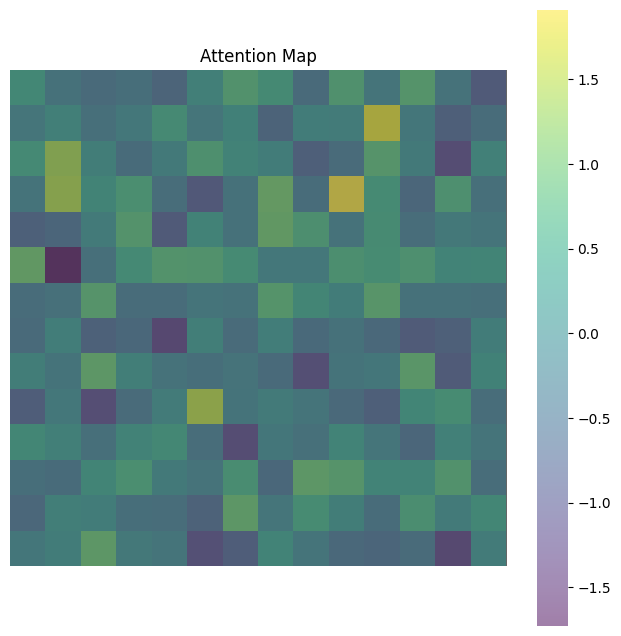

In [4]:
import torch
import timm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision import transforms
from PIL import Image
import os

# ================================
# 1. Load Trained Model
# ================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model path (Kaggle working directory)
model_path = "/kaggle/working/binaryvit_dog_vs_not_dog_best.pth"

# Load the BinaryViT model with fixed security warning
model = timm.create_model("deit_small_patch16_224", pretrained=False, num_classes=2)
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.to(device)
model.eval()

print("✅ Model loaded successfully from:", model_path)

# ================================
# 2. Define Preprocessing Function
# ================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ================================
# 3. Perform Inference on a Test Image
# ================================
test_img_path = "/kaggle/input/a/other/default/1/sample.jpg"  # Updated Path

if not os.path.exists(test_img_path):
    raise FileNotFoundError(f"❌ Test image not found: {test_img_path}")

# Load and preprocess image
image = Image.open(test_img_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Get Prediction
with torch.no_grad():
    output = model(image_tensor)
    predicted_class = torch.argmax(output, dim=1).item()
    label = "Dog" if predicted_class == 1 else "Not Dog"

print(f"✅ Predicted Class: {label}")

# Save Prediction Result
result_path = "/kaggle/working/prediction.txt"
with open(result_path, "w") as f:
    f.write(f"Predicted Class: {label}\n")
print(f"✅ Prediction result saved at: {result_path}")

# ================================
# 4. Extract and Visualize Attention Map (Fixed)
# ================================
attention_maps = []

def hook_fn(module, input, output):
    """Hook function to extract attention maps from self-attention layers."""
    attention_maps.append(output.detach().cpu())  # Store raw attention weights

# Find the last self-attention layer and register a hook
for name, module in model.named_modules():
    if "attn.proj" in name:  # Extract from the attention projection layer
        module.register_forward_hook(hook_fn)

with torch.no_grad():
    _ = model(image_tensor)  # Forward pass to trigger hook

if attention_maps:
    attn = attention_maps[-1]  # Extracted attention tensor
    attn = attn.mean(dim=1).squeeze(0).numpy()  # Average over heads

    # Reshape attention map correctly (DeiT uses 14x14 patches for 224x224 input)
    num_patches = 14 * 14  # 196 patches
    attn = attn[:num_patches]  # Select patch tokens, excluding CLS token
    attn = attn.reshape(14, 14)  # Convert to 2D grid

    # ================================
    # 5. Visualize Attention Map
    # ================================
    def visualize_attention(image, attention):
        """Plots the attention map overlaid on the image."""
        plt.figure(figsize=(8, 8))
        sns.heatmap(attention, cmap="viridis", alpha=0.5, square=True)
        
        # Resize image to match attention map shape
        resized_image = image.permute(1, 2, 0).cpu().numpy()
        plt.imshow(resized_image, alpha=0.6)
        
        plt.axis("off")
        plt.title("Attention Map")

        attention_map_path = "/kaggle/working/attention_map.png"
        plt.savefig(attention_map_path)
        print(f"✅ Attention Map saved at: {attention_map_path}")

    visualize_attention(image_tensor.squeeze(), attn)

else:
    print("❌ Attention map not available in this model.")
